### Importamos librerias:
* Quitamos alertas de <i>Sklearn.</i>

In [17]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

## Eliminamos warnings de sklearn
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore'
                        , category = ConvergenceWarning
                        , module = 'sklearn')

### Funciones:

In [2]:
def markdown(txt):
    display(Markdown(txt))

In [3]:
def plot(df, col):
    df_temp = df.groupby(col)['Survived']
    df_temp = df_temp.sum() / df_temp.count()
    
    Grafico = df_temp.plot(kind = 'barh'
                       , width = 0.5
                       , color = plt.get_cmap('Blues')(np.linspace(start = 0.15
                                           , stop = 0.85
                                           , num = len(df_temp)))
                       , stacked = True
                       , legend = False
                       , fontsize = 10)
    
    Grafico.set_xlim([0,0.85])
    Grafico.set_ylabel('')
    Grafico.grid(axis='x',alpha=0.25)
    Grafico.set_xticklabels(['{:3.0f} %'.format(x * 100) for x in Grafico.get_xticks()])
    [spine.set_visible(False) for spine in Grafico.spines.values()]
    Grafico.spines['left'].set_visible(True)

    plt.tick_params(left = False, bottom = False)
    plt.title(col)
    df_temp = None
    

In [4]:
def matriz(clf, X, y, Modelo = ''):
    mc = confusion_matrix(y, clf.predict(X))
    Total = sum(np.transpose(mc))
    mcr = np.transpose(np.round(np.transpose(mc) / Total * 100,2))
    MC = pd.DataFrame(mc, columns=['No', 'Si'])

    MC['index'] = ['No', 'Si']
    MC['No'] *= -1

    Grafico = MC.set_index('index').sort_values(['index']
                                                , ascending=False).plot(kind = 'barh'
                                                                        , stacked = True
                                                                        , width = 0.75
                                                                        , color=[['#c9c9c9','#e60000'],['#00c800','#c9c9c9']]
                                                                        , legend = False
                                                                        , figsize = (3,1.2))
    
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.gca().grid(axis='x',alpha=0)
    plt.gca().grid(axis='y',alpha=0)
    plt.gca().set_xlabel(Modelo + ': {:.2f}%'.format(clf.score(X, y) * 100)
                         , fontsize = 12
                         , alpha = 0.6)
    plt.gca().set_ylabel('')
    
    [spine.set_visible(False) for spine in plt.gca().spines.values()]
    
    return Grafico

### Importamos datos:
* Eliminamos columnas que contienen información con poco valor predictivo.
* Imputamos valores faltantantes en los campos <b>edad</b> (media del pasaje) y <b>puerto de embarque</b> (asignamos puerto mayoritario).

In [5]:
df = (pd.read_csv('data/train.csv', sep = ',', header = 0)
      .drop(['PassengerId','Name','Cabin'], axis='columns')
     )

df.fillna({'Age': df.Age.mean()
          , 'Embarked': df.Embarked.value_counts().index.tolist()[0]}, inplace = True)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,female,35.0,1,0,113803,53.1000,S
4,0,3,male,35.0,0,0,373450,8.0500,S


In [6]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [7]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Gráfico de impacto por cada una de las variables:

### Mortalidad en función de cada variable

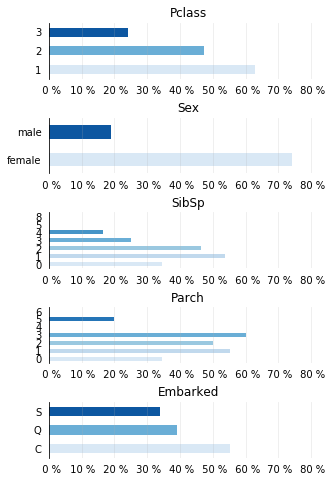

In [8]:
columnsList = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
markdown(f'### Mortalidad en función de cada variable')

fig = plt.figure(figsize =(5, 8)) 
fig.patch.set_facecolor('white')

plt.subplots_adjust(hspace = .7)

for i in range(1,len(columnsList) + 1):    
    plt.subplot(len(columnsList), 1, i)
    plot(df, columnsList[i -1])

plt.show()
plt.close()

* Convertimes variables no numéricas en valores numéricos.

In [9]:
BackUp = df

le = LabelEncoder()
for i in df.columns.tolist():
    if df[i].dtype == 'object':
        df[i]  =  df[[i]].apply(le.fit_transform)     
        
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,1,22.0,1,0,523,7.2500,2
1,1,1,0,38.0,1,0,596,71.2833,0
2,1,3,0,26.0,0,0,669,7.9250,2
3,1,1,0,35.0,1,0,49,53.1000,2
4,0,3,1,35.0,0,0,472,8.0500,2


### Dividimos los datos entre Test y Train.

In [11]:
X = df.iloc[:, 1:]
y = df['Survived']

XE, XT, ye, yt = train_test_split(X
                                  , y
                                  , test_size = 0.5
                                  , random_state = 0)

### Configuración de modelos.

In [12]:
Params = [{'Modelo': 'Regresión logística'
          , 'Clasificador': LogisticRegression(solver = 'lbfgs'
                                               , multi_class = 'multinomial'
                                               , class_weight = 'balanced')}
          , {'Modelo': 'Super Vector Machine'
          , 'Clasificador': SVC(gamma = 'scale')}
          , {'Modelo': 'Decision Tree Classifier'
          , 'Clasificador': DecisionTreeClassifier()}
          , {'Modelo': 'K Nearest Neighbors'
          , 'Clasificador': KNeighborsClassifier()}
          , {'Modelo': 'Multi-Layer Perceptron'
          , 'Clasificador': MLPClassifier()}
         ]


### Comparativa de los distintos modelos y <i>Matriz de confusión:</i>

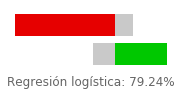

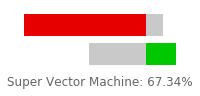

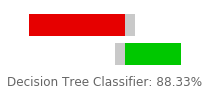

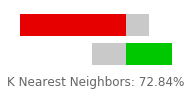

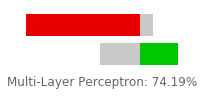

In [19]:
markdown(f'### Comparativa de los distintos modelos y <i>Matriz de confusión:</i>')
for i in Params:    
    clf = i['Clasificador']
    clf.fit(XE, ye)
    matriz(clf, X, y, i['Modelo'])
    

### Conclusiones:

El mejor modelo parece el Árbol de decisión, con un 87% de acierto, y quedan descartados el SVC, KNN y Multi_layer Perceptron por mostar un claro sobreajuste.